In [1]:
from VANE import VANE
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Pick a few variants from MS

A subset of 30 SNPs where randomly selected from the known 200 significant variants

In [42]:
ms_variants = ['rs35486093','rs11256593', 'rs112344141', 'rs1323292', 'rs72928038', 'rs78727559', 'rs1800693', 'rs10801908', 'rs6670198',
'rs62420820', 'rs1738074', 'rs4939490', 'rs9843355', 'rs11809700', 'rs35540610', 'rs1026916', 'rs1014486', 'rs6589706', 'rs11079784',
'rs11749040', 'rs631204', 'rs4808760', 'rs12478539', 'rs7977720', 'rs3809627', 'rs12365699', 'rs6032662', 'rs60600003', 'rs2546890', 'rs1465697']

### Processing LD blocks for set of tagging SNPs

It is not obligatory to initiate the object with leading SNPs

In [4]:
MS_variant = VANE(list_of_variants = ms_variants)

We process the tagging SNPs with a LD block, to get a possible set of causal variants. You can specify the target population from 1000 Genome for the LD block,
from here: https://rest.ensembl.org/documentation/info/variation_populations  
If None is indicated a white european population is used. 

Verbose option can be set to TRUE to print the details of the LD parsing script

In [5]:
df_with_positions = MS_variant.process_tag_variants(ld=0.7, population = "1000GENOMES:phase_3:CEU", verbose=False)

In [6]:
df_with_positions

,chromosome,position,ref,alt,rsid,tagging_snp
0,1,85258126,A,C,rs12561876,rs35486093
0,1,85277178,C,A,rs11161583,rs35486093
0,1,85283878,C,T,rs6693229,rs35486093
0,1,85253927,T,C,rs4074156,rs35486093
0,1,85249122,C,T,rs12743302,rs35486093
...,...,...,...,...,...,...
0,19,49319790,C,T,rs10414921,rs1465697
0,19,49311575,C,T,rs3760667,rs1465697
0,19,49384752,T,C,rs7254187,rs1465697
0,19,49387616,T,C,rs7251704,rs1465697


        In case that you want to use fine-mapped SNPs for any given LOCUS, you can use this function = process_list_finemapped()
        list_of_locus_name = List for how you want to call the locus. 
        list_of_finemapped = This is a list of lists. For each locus you want a list of the finemapped SNPs in rsid format.
        Both list_of_locus_name, and list_of_fiemapped SNPs need to be in order.
        
        Example: 
        
        You have three locus, locus 1, locus 2, and locus 3. You have three SNPs rs2, rs3, and rs4, finemapped to locus 1, 
        rs42, rs32, and rs11 finemapped to Locus 2, and rs111, rs321, and rs33, finemapped to locus 3.

        This how it should be formatted:

        list_of_locus_name = ['locus_1', 'locus_2', 'locus_3']
        list_of_finemapped = [['rs2', 'rs3', 'rs4'], ['rs42', 'rs32', 'rs11'], ['rs111', 'rs321', 'rs33']]

        This output a dataframe identical to the one outputted fron process_tag_variants()

### SNP 2 Gene querying

Now we need to map every SNP to a gene. We use OpenTargetGenetics machine learning powered algorithm from Gazal Et. Al 2022 Nat Genet. that combines multiple sources of data
and a Random Forest Classifier to calculate the probability of each SNP affecting a gene.

OpenTargetGenetics has open data availability, we download the source parquet files, merge, cleaned and re-formatted them into a single sql datafile for faster and
easier access. If you followed the detailed installation guide, the file location should be at  "base_files/clean_snp2gene.db"

In [7]:
snp_2_gene = MS_variant.query_snp_opentargets(df_with_positions, "base_files/clean_snp2gene.db")

### Merge and cleaning 

We merge and clean our two files recently created.

In [8]:
gene_to_rsid = MS_variant.merge_and_clean(snp_2_gene, df_with_positions)

We are returned a pandas dataframe with genes and the amount of SNPs mapped to them. 
You can further trim the list of genes using the amount of SNPs

In [9]:
gene_to_rsid.head()

,gene_id,rsid
0,ENSG00000013725,4
1,ENSG00000016402,1
2,ENSG00000019144,50
3,ENSG00000027697,9
4,ENSG00000067182,9


We now have our cleaned SNP 2 Gene file. You can also trim your list down using the information here.

In [10]:
MS_variant.snp_2_gene_clean

,rsid,gene_id,position,chromosome,ref,alt,overall_score,tagging_snp
13,rs767455,ENSG00000067182,6341779,12,T,C,0.506640,rs1800693
23,rs7970116,ENSG00000069493,9727518,12,A,G,0.300000,rs7977720
26,rs12709914,ENSG00000104901,49358133,19,C,T,0.400402,rs1465697
38,rs9894179,ENSG00000178852,47487727,17,C,A,0.367203,rs11079784
44,rs9914653,ENSG00000178852,47460029,17,T,C,0.367203,rs11079784
...,...,...,...,...,...,...,...,...
7258,rs11743463,ENSG00000171522,40360356,5,C,A,0.099598,rs11749040
7259,rs80057400,ENSG00000155849,37365874,7,T,C,0.232596,rs60600003
7260,rs12475946,ENSG00000152518,43115709,2,C,T,0.106237,rs12478539
7261,rs28482033,ENSG00000155849,37394597,7,T,C,0.199396,rs60600003


### Regulome DB 

Once we have the SNP2GENE table, we need to query regulomeDB. This table tend to be pretty big so we implemented two ways to deal with it.
First you can use the option snp_2_gene_all=None. If None, the whole tables saved in the object's instance. You can loop through the smaller chunks of DF 
if you are having troubles with querying RegulomeDB for a extensive amount of variants (usually 5k variants take about an hour to be processed). 
We can also use the save=True option, in case of memory troubles. If save=True, the DF will be saved as an instance of the object.

You can track progression using verbose=True

In [11]:
MS_variant.regulomedb_scoring(save=True, verbose=False)

### Cellular level processing

We create a list of Cells to retrieve the information from the main table. In this case, since we are studying a list of MS variants,
we are interested in lymph and brain cells. 

In [12]:
cell_list = ['B', 'T', 'mono', 'astrocyte', 'neutrophil', 'keratinocyte', 'melanocyte']

In [13]:
MS_variant.process_cells(cell_list)

,cell_specific,count,score,normalized score,gene
0,B,117,107.0,0.914530,ENSG00000067182
1,T,414,410.0,0.990338,ENSG00000067182
2,astrocyte,36,35.0,0.972222,ENSG00000067182
3,keratinocyte,54,47.0,0.870370,ENSG00000067182
4,melanocyte,18,16.0,0.888889,ENSG00000067182
...,...,...,...,...,...
331,astrocyte,4,0.0,0.000000,ENSG00000168811
332,keratinocyte,6,0.0,0.000000,ENSG00000168811
333,melanocyte,2,0.0,0.000000,ENSG00000168811
334,mono,10,-1.0,-0.100000,ENSG00000168811


#### Plotting cell results

If we want to check how's absolute Gene's epigenomic state is in each cell we can plot it this way:

<Axes: xlabel='None-cell_specific', ylabel='protein_gene'>

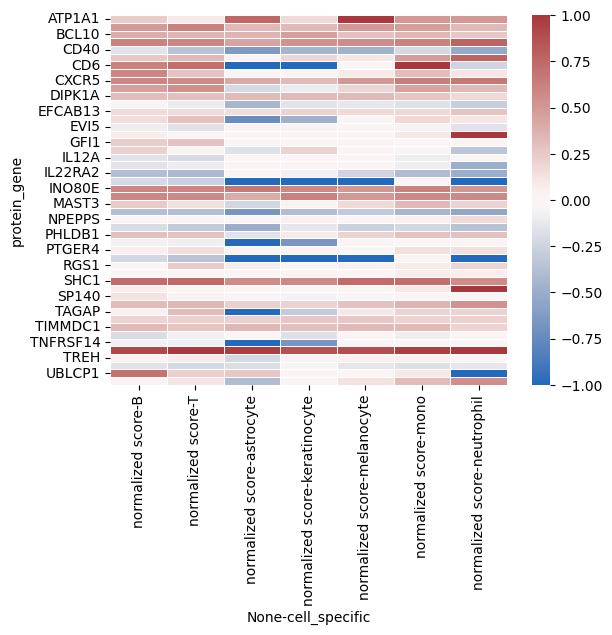

In [14]:
MS_variant.plot_cells()

To check f data for the heatmap you can call it by:

In [15]:
cell_genewise_standarize  = ((MS_variant.df_for_network.T - MS_variant.df_for_network.T.mean()) / MS_variant.df_for_network.T.std()).T

<Axes: xlabel='None-cell_specific', ylabel='protein_gene'>

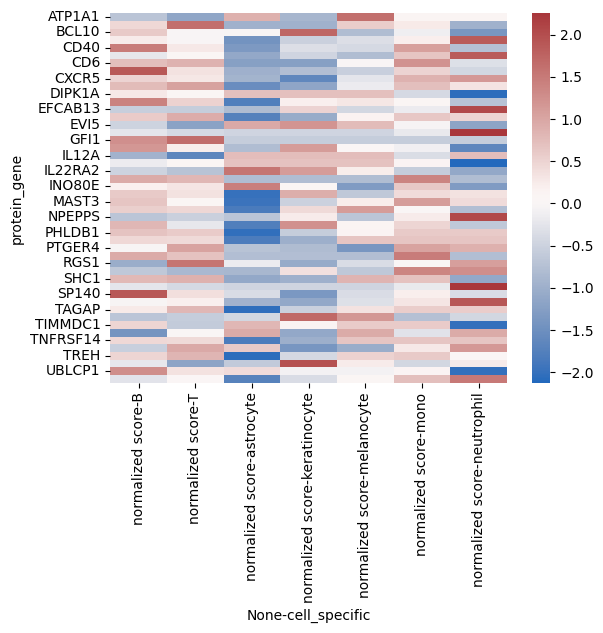

In [16]:
sns.heatmap(cell_genewise_standarize, cmap='vlag')

### Tissue/Organ specific 

In [17]:
organs_list = ['brain','spleen','thymus', 'lymphoid tissue', 'lymph node', 'skin']

In [18]:
MS_variant.process_organs(organs_list)

,organ_specific,count,score,normalized score,gene
0,brain,612,516.0,0.843137,ENSG00000067182
1,lymph node,27,1.0,0.037037,ENSG00000067182
2,lymphoid tissue,45,44.0,0.977778,ENSG00000067182
3,skin,405,381.0,0.940741,ENSG00000067182
4,spleen,54,53.0,0.981481,ENSG00000067182
...,...,...,...,...,...
283,lymph node,3,0.0,0.000000,ENSG00000168811
284,lymphoid tissue,5,0.0,0.000000,ENSG00000168811
285,skin,45,0.0,0.000000,ENSG00000168811
286,spleen,6,0.0,0.000000,ENSG00000168811


<Axes: xlabel='None-organ_specific', ylabel='protein_gene'>

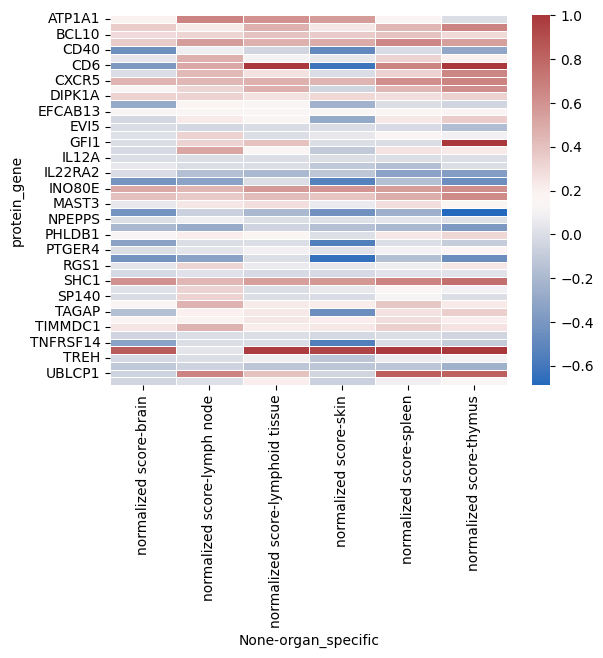

In [19]:
MS_variant.plot_organs()

### Network Analysis

In [20]:
from VANE import VANE_network

#### T cell analysis

We are going to create networks for a few an analyze 

In [21]:
T_cell_network = VANE_network(network_folder = 'base_files/cell_networks/', df_for_network=MS_variant.df_for_network)

The python package already comes with a dictionary between regulomeDB cells and Human protein atlas. A custom python dic can be easily made

In [22]:
T_cell_network.cell_dicts

{'B': 'B-Cell',
 'T': 'T-Cell',
 'mono': 'Monocytes',
 'astrocyte': 'Astrocytes',
 'oligodendrocyte': 'Oligodendrocytes'}

In [23]:
T_cell_network.create_cellular_network(cell = 'T', epigenome_threshold = 0)

['ATP1A1', 'BACH2', 'BCL10', 'CAVIN1', 'CD58', 'CD6', 'CLEC2D', 'CXCR5', 'DDX6', 'DIPK1A', 'EFCAB13', 'ELMO1', 'GDPD3', 'GFI1', 'IFNGR1', 'INO80E', 'INTS8', 'MAST3', 'NPEPPS', 'PHLDB1', 'PTGER4', 'RGS1', 'SHC1', 'SLX1A', 'SP140', 'STAT3', 'TAGAP', 'TBKBP1', 'TIMMDC1', 'TNFRSF1A', 'TREH', 'UBLCP1', 'ZFP36L2']


#### The number of nodes in our subgraph can be called this way:

In [24]:
T_cell_network.graph.number_of_nodes()

33

#### The number of edges in our subgraph can be called this way:

In [25]:
T_cell_network.graph.number_of_edges()

4

#### Compute CI intervals and P value

We bootstrap the original cellular network to create an empiric distribution. We can estimate the one-tail P value using the following formula:

pval = (1+sum(s >= s0))/(N+1)

Davison and Hinkley (1997), Bootstrap Methods and their Application, p. 141. 

In [26]:
CI, pval = T_cell_network.calculate_p_value()

In [27]:
CI

(0.0, 4.0)

In [28]:
pval

0.024975024975024976

<Axes: xlabel='Edge Count', ylabel='Frequency in bootstrapping'>

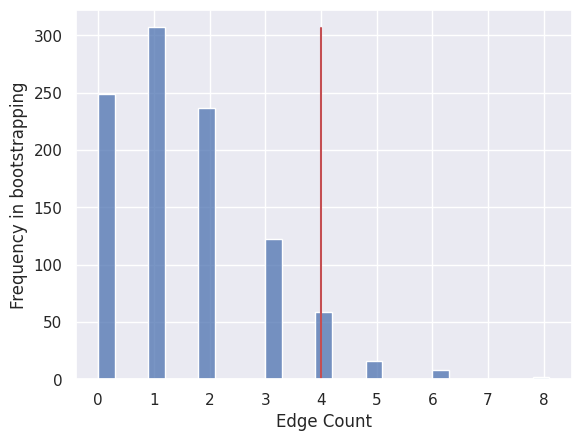

In [29]:
T_cell_network.plot_bootstrap()

#### Astrocytes

In [30]:
Astrocytes_cell_network = VANE_network(network_folder = 'base_files/cell_networks/', df_for_network=MS_variant.df_for_network)

Since we don't have in our original dictionary the specific cellular method 

In [31]:
Astrocytes_cell_network.create_cellular_network(cell = 'astrocyte', epigenome_threshold = 0)

['ATP1A1', 'BACH2', 'BCL10', 'CAVIN1', 'CD58', 'CXCR5', 'DIPK1A', 'EFCAB13', 'EVI5', 'INO80E', 'INTS8', 'PTGER4', 'RGS1', 'SHC1', 'STAT3', 'TBKBP1', 'TIMMDC1', 'TNFRSF1A', 'UBLCP1']


In [32]:
Astrocytes_cell_network.graph.number_of_nodes()

18

In [33]:
Astrocytes_cell_network.graph.number_of_edges()

3

#### P value calculations

In [34]:
CI, pval = Astrocytes_cell_network.calculate_p_value()

In [35]:
CI

(0.0, 2.0)

In [36]:
pval

0.000999000999000999

<Axes: xlabel='Edge Count', ylabel='Frequency in bootstrapping'>

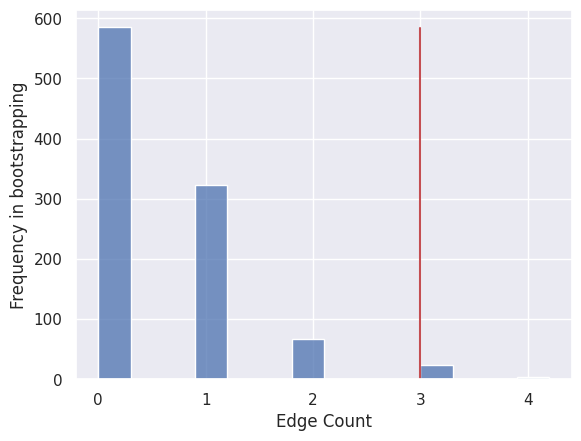

In [37]:
Astrocytes_cell_network.plot_bootstrap()